In [0]:
#importing necessary libs
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.tokenize import RegexpTokenizer

In [306]:
#importing required training file
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [0]:
import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [308]:
#exploring the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [309]:
#analysis of null values
total_null = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total_null],axis = 1,keys=['Total_null'])
missing_data



,Total_null
region_2,46708
designation,23647
user_name,19393
region_1,12754
price,5569
province,35
country,35
variety,0
winery,0
points,0


In [310]:
#Data-Cleaning Begins
#since there is lot of data its better to get rid of NaN values
data=data.dropna(subset=['price'])
data=data.dropna(subset=['country'])
total_null = data.isnull().sum().sort_values(ascending=False)
total_null

region_2              41263
designation           21929
user_name             18642
region_1              11858
variety                   0
winery                    0
province                  0
price                     0
points                    0
review_description        0
review_title              0
country                   0
dtype: int64

In [311]:
#finding duplicate reviews
print("Total examples: ", data.shape[0])
print("same title and description: ", data[data.duplicated(['review_description','review_title'])].shape[0])

Total examples:  77057
same title and description:  4730


In [0]:
#finding duplicate entries and deleting them
data=data.drop_duplicates(['review_description','review_title'])
data=data.reset_index(drop=True)

In [0]:
#filling rest of the missing values with -1
data=data.fillna(-1)

In [314]:
#using the NLTK library, lowercasing all the descriptions:
data['review_description']= data['review_description'].str.lower()
#using regular expressions(regex library) to remove unnecessary elements like commas etc:
data['review_description']= data['review_description'].apply(lambda x: re.sub('[^a-zA-Z]',' ', x)) 
data['review_description']


0        classic chardonnay aromas of apple  pear and h...
1        this wine is near equal parts syrah and merlot...
2        barolo conca opens with inky dark concentratio...
3        it s impressive what a small addition of sauvi...
4        this ripe  sweet wine is rich and full of drie...
                               ...                        
72322    made in a drier  tarter style than the winery ...
72323    hot earth  baked cherry and mild vanilla aroma...
72324    pungent  high pitched notes of turmeric and dr...
72325    this is a wine that s not just lively and frui...
72326    a big  rich  vital cabernet with immediate att...
Name: review_description, Length: 72327, dtype: object

In [315]:
#senetences are too large hence its important to tokenise the descriptions into list of words:
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = data['review_description'].apply(tokenizer.tokenize)
words_descriptions.head()

0    [classic, chardonnay, aromas, of, apple, pear,...
1    [this, wine, is, near, equal, parts, syrah, an...
2    [barolo, conca, opens, with, inky, dark, conce...
3    [it, s, impressive, what, a, small, addition, ...
4    [this, ripe, sweet, wine, is, rich, and, full,...
Name: review_description, dtype: object

In [316]:
#creating Vocabulary:
all_words = [word for tokens in words_descriptions for word in tokens]
data['description_lengths'] = [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s are the total words and vocabulary size is  %s" % (len(all_words), len(VOCAB)))

3004350 are the total words and vocabulary size is  24594


In [317]:
#finding most common words in Vocab:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(90)

[('and', 195353),
 ('the', 123890),
 ('a', 101504),
 ('of', 96298),
 ('with', 66956),
 ('this', 64002),
 ('is', 53513),
 ('it', 50510),
 ('wine', 44092),
 ('in', 36760),
 ('flavors', 36304),
 ('to', 32087),
 ('s', 30886),
 ('fruit', 27274),
 ('on', 25557),
 ('that', 22416),
 ('palate', 20582),
 ('aromas', 20045),
 ('from', 19208),
 ('finish', 19150),
 ('acidity', 18676),
 ('but', 17945),
 ('tannins', 17568),
 ('cherry', 17174),
 ('drink', 17174),
 ('black', 16566),
 ('ripe', 15082),
 ('are', 14514),
 ('has', 13552),
 ('for', 12667),
 ('red', 12331),
 ('by', 11315),
 ('oak', 10800),
 ('notes', 10475),
 ('dry', 10441),
 ('spice', 10263),
 ('as', 10178),
 ('its', 10076),
 ('now', 10033),
 ('an', 9968),
 ('rich', 9906),
 ('nose', 9345),
 ('berry', 9108),
 ('full', 9008),
 ('fresh', 8836),
 ('plum', 8140),
 ('blend', 8009),
 ('soft', 7670),
 ('sweet', 7569),
 ('well', 7552),
 ('fruits', 7412),
 ('cabernet', 7270),
 ('light', 7162),
 ('blackberry', 7149),
 ('apple', 7082),
 ('texture', 6926)

In [318]:
#analysing similar words and cleaning the review description to decrease the number of words
import nltk
nltk.download('stopwords')
stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda x: [word for word in x if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda x: [ps.stem(word) for word in x])
data['description_cleaned'] = words_descriptions.apply(lambda x: ' '.join(x))
all_words = [word for tokens in words_descriptions for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1828191 words total, with a vocabulary size of 17417


[('wine', 45604),
 ('flavor', 41066),
 ('fruit', 34914),
 ('finish', 22414),
 ('acid', 21491),
 ('aroma', 20866),
 ('palat', 20651),
 ('cherri', 20022),
 ('drink', 19346),
 ('tannin', 18883),
 ('black', 16588),
 ('ripe', 16117),
 ('dri', 15321),
 ('note', 13461),
 ('spice', 12861),
 ('red', 12461),
 ('rich', 12413),
 ('fresh', 11147),
 ('oak', 11128),
 ('show', 10512),
 ('berri', 10461),
 ('nose', 9354),
 ('blend', 9159),
 ('full', 9061),
 ('textur', 8909),
 ('plum', 8908),
 ('sweet', 8870),
 ('balanc', 8674),
 ('blackberri', 8640),
 ('bodi', 8488),
 ('offer', 8301),
 ('appl', 8077),
 ('soft', 7978),
 ('age', 7916),
 ('well', 7560),
 ('cabernet', 7388),
 ('light', 7376),
 ('structur', 7360),
 ('crisp', 7199),
 ('dark', 6795),
 ('raspberri', 6711),
 ('fruiti', 6593),
 ('herb', 6443),
 ('vanilla', 6339),
 ('give', 6297),
 ('hint', 6089),
 ('miner', 6029),
 ('year', 5931),
 ('pepper', 5930),
 ('citru', 5865),
 ('white', 5803),
 ('good', 5690),
 ('touch', 5675),
 ('juici', 5523),
 ('bright

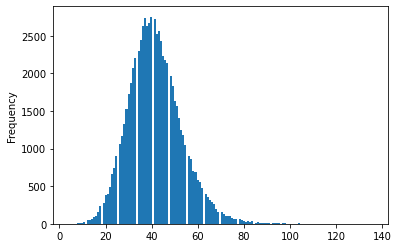

In [319]:
#visualizing length of description 
data['description_lengths'].plot.hist(bins=150)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed3a6c79b0>,
      dtype=object)

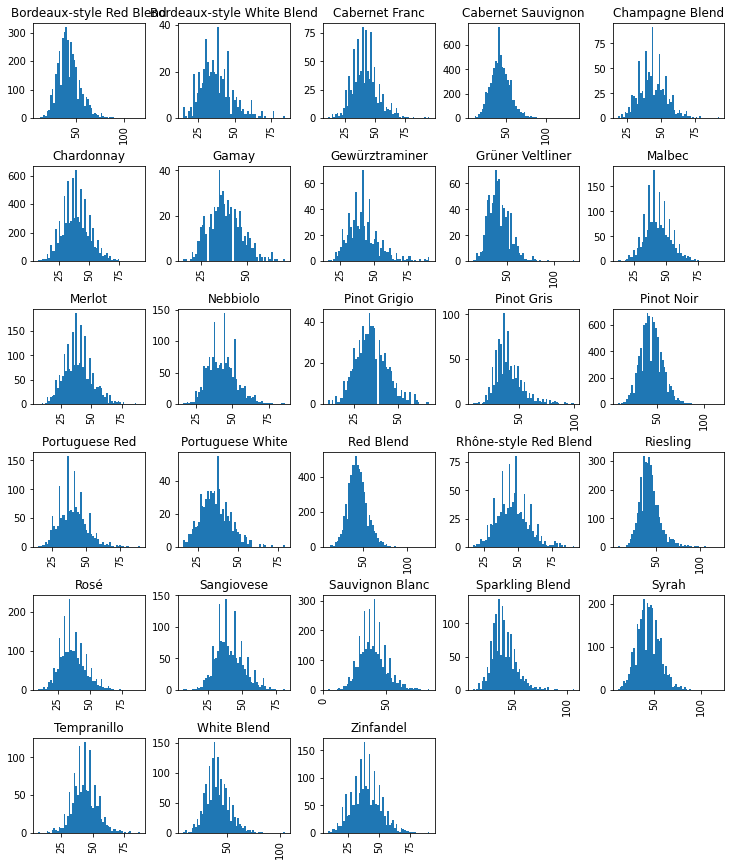

In [320]:
#visualizing how description_length might affect the prediction about variety
data.hist(column='description_lengths',by='variety',bins=60,figsize=(12,15))

In [321]:
import string
from nltk.corpus import stopwords
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

data['description_cleaned'].head(5).apply(text_process)

0    [classic, chardonnay, aroma, appl, pear, hay, ...
1    [wine, near, equal, part, syrah, merlot, balan...
2    [barolo, conca, open, inki, dark, concentr, so...
3    [impress, small, addit, sauvignon, gri, muscad...
4    [ripe, sweet, wine, rich, full, dri, fresh, fr...
Name: description_cleaned, dtype: object

In [0]:
#tokenize and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(data['description_cleaned'])

In [324]:
print(len(bow_transformer.vocabulary_))

17394


In [0]:
#encoding the column variety
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#le = LabelEncoder()
#data['country'] = le.fit_transform(data['country'])
le2 = LabelEncoder()
data['variety'] = le2.fit_transform(data['variety'])

In [326]:
data

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety,description_lengths,description_cleaned
0,-1,1,Andrew Peace 2007 Peace Family Vineyard Chardo...,classic chardonnay aromas of apple pear and h...,Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,-1,Andrew Peace,5,32,classic chardonnay aroma appl pear hay lead pa...
1,@wawinereport,35,North by Northwest 2014 Red (Columbia Valley (...,this wine is near equal parts syrah and merlot...,-1,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,17,40,wine near equal part syrah merlot balanc caber...
2,-1,18,Renato Ratti 2007 Conca (Barolo),barolo conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,-1,Renato Ratti,11,43,barolo conca open inki dark concentr sooth aro...
3,@vossroger,11,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,it s impressive what a small addition of sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,-1,Domaine l'Ancienne Cure,1,32,impress small addit sauvignon gri muscadel sau...
4,@vossroger,11,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,this ripe sweet wine is rich and full of drie...,Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,-1,Château du Cèdre,9,40,ripe sweet wine rich full dri fresh fruit flav...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72322,-1,35,La Crema 2012 Chardonnay (Arroyo Seco),made in a drier tarter style than the winery ...,-1,90,30.0,California,Arroyo Seco,Central Coast,La Crema,5,38,made drier tarter style wineri russian river b...
72323,@wineschach,32,Montecillo 2007 Crianza (Rioja),hot earth baked cherry and mild vanilla aroma...,Crianza,84,12.0,Northern Spain,Rioja,-1,Montecillo,25,40,hot earth bake cherri mild vanilla aroma come ...
72324,-1,35,Vivác Winery 2008 Single Vineyard Cabernet Sau...,pungent high pitched notes of turmeric and dr...,Single Vineyard,85,21.0,New Mexico,New Mexico,-1,Vivác Winery,3,38,pungent high pitch note turmer dri flower hit ...
72325,@vossroger,11,Domaine de la Madone 2014 Nouveau (Beaujolais...,this is a wine that s not just lively and frui...,Nouveau,87,14.0,Beaujolais,Beaujolais-Villages,-1,Domaine de la Madone,6,29,wine live fruiti weight structur well keep ins...


In [0]:
#training and validating the data
from sklearn.model_selection import train_test_split
X = data[['country','points','price','description_lengths','description_cleaned']]
msg_train,msg_test,label_train,label_test = train_test_split(data['description_cleaned'],data['variety'],test_size=0.3)


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [0]:
#assembling several steps that can be cross-validated together using Pipeline
# 1.Transforming description into a sparse matrix of n-gram counts.
# 2.Performs the TF-IDF transformation from a provided matrix of counts.(processed from previous step)
# 3. Classifying using 2 methods: RandomForestClassifier and KNN
pipeline = Pipeline([
                     ('bow',CountVectorizer(analyzer=text_process)),
                     ('tfid',TfidfTransformer()),
                     ('classifier',RandomForestClassifier())
])

In [0]:
#fitting and predicting fot training set
pipeline.fit(msg_train,label_train)
predictions=pipeline.predict(msg_test)

In [331]:
#printing out the classification report
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions))




              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1225
           1       0.68      0.09      0.16       146
           2       0.87      0.12      0.21       281
           3       0.51      0.76      0.61      2144
           4       0.76      0.25      0.38       267
           5       0.57      0.96      0.71      2494
           6       0.77      0.20      0.32       181
           7       0.92      0.42      0.58       216
           8       0.89      0.50      0.64       250
           9       0.64      0.36      0.46       574
          10       0.84      0.29      0.43       670
          11       0.69      0.65      0.67       545
          12       0.84      0.36      0.51       231
          13       0.94      0.33      0.49       295
          14       0.60      0.88      0.72      2938
          15       0.70      0.40      0.51       505
          16       0.71      0.17      0.28       212
          17       0.59    

In [333]:
#uploading the testing file
rom google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [0]:
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [0]:
#evaluation on testing test:

from sklearn.metrics import accuracy_score
test=test.dropna(subset=['price'])
test=test.dropna(subset=['country'])
total_null1 = test.isnull().sum().sort_values(ascending=False)
test=test.drop_duplicates(['review_description','review_title'])
test=test.reset_index(drop=True)
test=test.fillna(-1)
#using the NLTK library, lowercasing all the descriptions:
test['review_description']= test['review_description'].str.lower()
#using regular expressions(regex library) to remove unnecessary elements like commas etc:
test['review_description']= test['review_description'].apply(lambda x: re.sub('[^a-zA-Z]',' ', x)) 
#senetences are too large hence its important to tokenise the descriptions into list of words:
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = test['review_description'].apply(tokenizer.tokenize)
words_descriptions.head()
#creating Vocabulary:
all_words = [word for tokens in words_descriptions for word in tokens]
test['description_lengths'] = [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(90)
import nltk
stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda x: [word for word in x if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda x: [ps.stem(word) for word in x])
test['description_cleaned'] = words_descriptions.apply(lambda x: ' '.join(x))
all_words = [word for tokens in words_descriptions for word in tokens]
VOCAB = sorted(list(set(all_words)))
#print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
count_all_words = Counter(all_words)
count_all_words.most_common(100)
import string
from nltk.corpus import stopwords
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

test['description_cleaned'].head(5).apply(text_process)
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(test['description_cleaned'])





In [0]:
#predictions for testing set
predictions = pipeline.predict(test["description_cleaned"])

In [0]:
#decoding the predicted values of variety
predicted_variety= list(le2.inverse_transform(predictions))

In [0]:
#appending the predicted values back to csv file
test['predicted_variety'] = predicted_variety

In [352]:
#removing unncessary columns:
test.drop(columns=['description_lengths', 'description_cleaned'])
test
test.to_csv('file1.csv') 
#END

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,description_lengths,description_cleaned,predicted_variety
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,nicely differentiated from the companion stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars,41,nice differenti companion stewart bottl athena...,Pinot Noir
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,charred smoky herbal aromas of blackberry tr...,Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,-1,Mendoza Vineyards,53,char smoki herbal aroma blackberri trend direc...,Malbec
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),slightly sour and funky in earth this is a re...,-1,87,38.0,California,Coombsville,Napa,Prime,45,slightli sour funki earth restrain white age m...,Chardonnay
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,this concentrated midnight black malbec deliv...,Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,-1,Bodega Cuarto Dominio,44,concentr midnight black malbec deliv aromat go...,Malbec
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,earthy aromas suggesting grilled porcini leat...,-1,90,49.0,Tuscany,Brunello di Montalcino,-1,SassodiSole,44,earthi aroma suggest grill porcini leather til...,Red Blend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18969,@gordone_cellars,US,Yorkville Cellars 2013 Rennie Vineyard Caberne...,clearly focused and fruit driven this wine ha...,Rennie Vineyard,91,34.0,California,Yorkville Highlands,North Coast,Yorkville Cellars,45,clearli focus fruit driven wine bonanza dark f...,Chardonnay
18970,@laurbuzz,France,Château Ribaute 2015 Senhal d'Aric Rosé (Corbi...,herbal tones of bay and rosemary are upfront o...,Senhal d'Aric,84,20.0,Languedoc-Roussillon,Corbières,-1,Château Ribaute,41,herbal tone bay rosemari upfront nose copper p...,Rosé
18971,@mattkettmann,US,Daou 2014 Reserve Cabernet Sauvignon (Paso Rob...,mocha cream pencil shaving and dried herb aro...,Reserve,94,85.0,California,Paso Robles,Central Coast,Daou,60,mocha cream pencil shave dri herb aroma set ba...,Pinot Noir
18972,@wineschach,Spain,Peñascal 2011 Tempranillo Rosé (Vino de la Tie...,loud citrus and berry aromas precede an overlo...,Tempranillo,80,9.0,Northern Spain,Vino de la Tierra de Castilla y León,-1,Peñascal,19,loud citru berri aroma preced overload palat c...,Malbec
